In [1]:
"""
A Neural Machine Translation (NMT) model designed for date format conversion. Using the attention mechanism,
it translates human-readable dates in various formats (e.g., "25th of June, 2009" "03/30/1968" and more)
into standardized machine-readable formats like YYYY-MM-DD (e.g., "2009-06-25").
"""

import os
from utils_nmt import *
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Bidirectional, RepeatVector, Dense, Activation
from tensorflow.keras.layers import Dot, Concatenate
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, ModelCheckpoint

seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)
%matplotlib inline

In [2]:
# LOAD DATASET
m = 10000  # Training samples (human-readable dates and their equivalent, standardized, machine-readable dates)
dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(m)
print(dataset[:10])
print(human_vocab)
print(machine_vocab)

100%|██████████| 10000/10000 [00:00<00:00, 94866.71it/s]

[('tuesday august 16 2016', '2016-08-16'), ('november 7 2011', '2011-11-07'), ('22 03 93', '1993-03-22'), ('apr 18 1984', '1984-04-18'), ('wednesday march 25 1998', '1998-03-25'), ('11 may 1992', '1992-05-11'), ('11 apr 2013', '2013-04-11'), ('tuesday september 30 1986', '1986-09-30'), ('april 25 1996', '1996-04-25'), ('march 18 2002', '2002-03-18')]
{' ': 0, '.': 1, '/': 2, '0': 3, '1': 4, '2': 5, '3': 6, '4': 7, '5': 8, '6': 9, '7': 10, '8': 11, '9': 12, 'a': 13, 'b': 14, 'c': 15, 'd': 16, 'e': 17, 'f': 18, 'g': 19, 'h': 20, 'i': 21, 'j': 22, 'l': 23, 'm': 24, 'n': 25, 'o': 26, 'p': 27, 'r': 28, 's': 29, 't': 30, 'u': 31, 'v': 32, 'w': 33, 'y': 34, '<unk>': 35, '<pad>': 36}
{'-': 0, '0': 1, '1': 2, '2': 3, '3': 4, '4': 5, '5': 6, '6': 7, '7': 8, '8': 9, '9': 10}


In [3]:
# Note:
# - dataset: a list of tuples of (human-readable date, machine-readable date).
# - human_vocab: a python dictionary mapping all characters used in the human-readable dates to an integer-valued index.
# - machine_vocab: a python dictionary mapping all characters used in machine-readable dates to an integer-valued index.
# - inv_machine_vocab: the inverse dictionary of machine_vocab, mapping from indices back to characters.

In [4]:
# PROCESS DATASET
Tx = 30  # Set to 30. Maximum length of a human-readable date; longer inputs will be truncated
Ty = 10  # Set to 10 because "YYYY-MM-DD" has 10 characters
X_train, Y_train, Xoh_train, Yoh_train, \
    X_cv, Y_cv, Xoh_cv, Yoh_cv, \
    X_test, Y_test, Xoh_test, Yoh_test = preprocess_and_split_data(dataset, human_vocab, machine_vocab,
                                                                   Tx, Ty, validation=True)

In [5]:
# Print shapes to verify the split
print("-------- The shapes for the various datasets --------")
print(f"X_train: {X_train.shape}, Y_train: {Y_train.shape}")
print(f"X_cv: {X_cv.shape}, Y_cv: {Y_cv.shape}")
print(f"X_test: {X_test.shape}, Y_test: {Y_test.shape}")
print(f"Xoh_train: {Xoh_train.shape}, Yoh_train: {Yoh_train.shape}")
print(f"Xoh_cv: {Xoh_cv.shape}, Yoh_cv: {Yoh_cv.shape}")
print(f"Xoh_test: {Xoh_test.shape}, Yoh_test: {Yoh_test.shape}")

-------- The shapes for the various datasets --------
X_train: (7000, 30), Y_train: (7000, 10)
X_cv: (1500, 30), Y_cv: (1500, 10)
X_test: (1500, 30), Y_test: (1500, 10)
Xoh_train: (7000, 30, 37), Yoh_train: (7000, 10, 11)
Xoh_cv: (1500, 30, 37), Yoh_cv: (1500, 10, 11)
Xoh_test: (1500, 30, 37), Yoh_test: (1500, 10, 11)


In [6]:
# Verification using one example in the dataset
index = 0
# Display source and target dates
print(f"\nSource date: {dataset[index][0]} & Target date: {dataset[index][1]}\n")

# Display preprocessed data
print(f"Source (indices): {X_train[index]}")
print(f"Target (indices): {Y_train[index]}\n")

# Display one-hot encoded data
print(f"Source (one-hot): {Xoh_train[index]}\n")
print(f"Target (one-hot): {Yoh_train[index]}")


Source date: tuesday august 16 2016 & Target date: 2016-08-16

Source (indices): [ 4  9  0 29 17 27  0  4 12 11  4 36 36 36 36 36 36 36 36 36 36 36 36 36
 36 36 36 36 36 36]
Target (indices): [ 2 10  9  2  0  1 10  0  2  7]

Source (one-hot): [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]

Target (one-hot): [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


In [7]:
# NEURAL MACHINE TRANSLATION WITH ATTENTION (NMT)
# Note: Two functions are needed to build our NMT: model() and one_step_attention().
# The function model() will call the layers in one_step_attention()  Ty times using a for-loop. One should not
# reinitialize the weights every time (i.e., all Ty  steps should have shared weights)

# Defining shared layers as global variables
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
densor1 = Dense(10, activation="tanh")
densor2 = Dense(1, activation="relu")
activator = Activation(activation=softmax, name='attention_weights')  # Custom softmax(axis=1) found in utils_nmt.py
dotor = Dot(axes=1)

In [8]:
# Implementing the one_step_attention()
def one_step_attention(a, s_prev):
    """
    Performs one step of the attention mechanism, outputting a context vector. The context vector
    is computed as the dot product of the attention weights (alphas) and the hidden states (a) of
    the Bi-LSTM.

    Arguments:
        a (numpy.ndarray): Hidden states output of the Bi-LSTM, of shape (m, Tx, 2*n_a), where:
            - m: Number of training examples.
            - Tx: Length of the input sequence.
            - 2*n_a: Dimension of the Bi-LSTM hidden states (concatenation of forward and backward LSTM states).
        s_prev (numpy.ndarray): Previous hidden state of the post-attention LSTM, of shape (m, n_s), where:
            - n_s: Dimension of the post-attention LSTM hidden state.

    Returns:
        context (numpy.ndarray): The context vector, of shape (m, 1, 2*n_a), to be used as input to the next
        post-attention LSTM cell.

    Notes:
        - This is one step of attention, and it is repeated for each time step in a sequence-to-sequence model.
        - The function assumes pre-initialized layers (`repeator`, `concatenator`, `densor1`, `densor2`, `activator`,
        `dotor`) defined globally, which are responsible for repeating, concatenating, and transforming the inputs.

    """
    # Repeat s_prev to match the shape of a
    s_prev = repeator(s_prev)

    # Concatenate a and s_prev along the last axis
    concat = concatenator([a, s_prev])

    # Compute intermediate energies using a small fully-connected neural network (densor1)
    e = densor1(concat)

    # Compute the energy scores from intermediate energies using a small fully-connected neural network (densor2)
    energies = densor2(e)

    # Compute attention weights using a softmax activation
    alphas = activator(energies)

    # Compute the context vector as a weighted sum of alphas and a
    context = dotor([alphas, a])

    return context

In [9]:
# Build the final model
n_a = 32  # The number of units for the pre-attention, bidirectional LSTM's hidden state 'a'
n_s = 64  # THe number of units for the post-attention LSTM's hidden state "s"

post_activation_LSTM_cell = LSTM(n_s, return_state=True, return_sequences=True)  # The post-attention LSTM cell.
output_layer = Dense(len(machine_vocab), activation=softmax, name='OutputLayer')

In [10]:
def model_nmt(Tx, Ty, n_a, n_s, human_vocab_size, machine_vocab_size):
    """
    Defines a sequence-to-sequence model with an attention mechanism to convert
    input sequences (human-readable dates. e.g., "25th of June, 2009,") to output sequences
    (machine-readable dates. e.g., 2009-06-25).

    Arguments:
        Tx (int): Maximum length of human-readable date strings.
        Ty (int): Length of the output sequence (e.g., the fixed length of machine-readable date strings).
        n_a (int): Hidden state size of the pre-attention Bi-LSTM.
        n_s (int): Hidden state size of the post-attention LSTM.
        human_vocab_size (int): Size of the python dictionary "human_vocab"
        machine_vocab_size (int): Size of the python dictionary "machine_vocab"

    Returns:
        model (keras.Model): Keras model instance

    Workflow:
        1. Define the inputs, including:
            - `X`: Input sequence of shape `(Tx, human_vocab_size)`.
            - `s0`: Initial hidden state of shape `(n_s,)`.
            - `c0`: Initial cell state of shape `(n_s,)`.
        2. Pass the input `X` through a Bidirectional LSTM (Bi-LSTM) to obtain hidden states `a` (pre-attention representation).
        3. For each timestep `t` in the output sequence (length `Ty`):
            - Compute the context vector `context` using the attention mechanism (`one_step_attention`).
            - Update the hidden state `s` and cell state `c` of the post-attention LSTM using the `context` vector.
            - Generate the output for timestep `t` using a Dense layer applied to `s`.
            - Append the output to the `outputs` list.
        4. Create and return the final model instance.

    """
    # Define the input sequence of shape (Tx, human_vocab_size)
    X = Input(shape=(Tx, human_vocab_size))

    # Define the initial hidden state and cell state
    s0 = Input(shape=(n_s,), name='s0')  # Initial hidden state
    c0 = Input(shape=(n_s,), name='c0')  # Initial cell state

    # Initialize the current hidden and cell states
    s = s0
    c = c0

    # Initialize an empty list to store the outputs for each timestep
    outputs = []

    # Step 1: Define the pre-attention Bi-LSTM.
    a = Bidirectional(LSTM(units=n_a, return_sequences=True))(X)

    # Step 2: Iterate for Ty time steps
    for t in range(Ty):
        # Step 2.A: Compute the context vector using the attention mechanism
        context = one_step_attention(a, s)  # Output shape: (None, 1, 2*n_a)
        # context = tf.keras.layers.Reshape((2*n_a, ))(context)  # Removes the extra dimension to return (None, 2*n_a)
        
        # Step 2.B: Update the hidden and cell states using the post-attention LSTM
        # The LSTM takes `context` as input along with the previous hidden state (s) and previous cell state (c)
        _, s, c = post_activation_LSTM_cell(inputs=context, initial_state=[s, c])

        # Step 2.C: Generate the output for the current timestep by applying Dense layer to the hidden state output
        # of the post-attention LSTM
        out = output_layer(s)

        # Step 2.D: Append the output for the current timestep to the outputs list
        outputs.append(out)

    # Step 3: Define the model that takes three inputs (X, s0, c0) and produces the outputs
    nmt = Model(inputs=[X, s0, c0], outputs=outputs)

    return nmt

In [11]:
model = model_nmt(Tx, Ty, n_a, n_s, len(human_vocab), len(machine_vocab))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 30, 37)]             0         []                            
                                                                                                  
 s0 (InputLayer)             [(None, 64)]                 0         []                            
                                                                                                  
 bidirectional (Bidirection  (None, 30, 64)               17920     ['input_1[0][0]']             
 al)                                                                                              
                                                                                                  
 repeat_vector (RepeatVecto  (None, 30, 64)               0         ['s0[0][0]',              

In [12]:
# COMPILE AND TRAIN THE MODEL
# Define the initial learning rate and decay rate
initial_lr = 0.005
decay = 0.01


# Define the learning rate schedule
def lr_schedule(epoch, decay_rate=decay):
    return initial_lr / (1 + decay_rate * epoch)


# Create the optimizer
opt = Adam(learning_rate=initial_lr, beta_1=0.9, beta_2=0.999)

In [13]:
# Compile the model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
# Add the callbacks
initial_weights_path = os.path.join(os.getcwd(), "models", "model_weights.h5")
weights_path = os.path.join(os.getcwd(), "models", "trained_weights.h5")
checkpoint_path = os.path.join(os.getcwd(), "models", "checkpoint_model.h5")

lr_scheduler = LearningRateScheduler(lr_schedule)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=8, factor=0.2, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=20,  restore_best_weights=True)
check_point = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_weights_only=True, save_best_only=True)

In [15]:
# Train the model
s0train = np.zeros((len(X_train), n_s))
c0train = np.zeros((len(X_train), n_s))
s0cv = np.zeros((len(X_cv), n_s))
c0cv = np.zeros((len(X_cv), n_s))

outputs_train = list(Yoh_train.swapaxes(0, 1))  # Swapping is required. See note below.
outputs_cv = list(Yoh_cv.swapaxes(0, 1))
outputs_test = list(Yoh_test.swapaxes(0, 1))

hist = model.fit([Xoh_train, s0train, c0train], outputs_train,
                 validation_data=([Xoh_cv, s0cv, c0cv], outputs_cv),
                 epochs=1,
                 batch_size=32,
                 callbacks=lr_scheduler)

219/219 [==============================] - 13s 24ms/step - loss: 12.7122 - OutputLayer_loss: 0.6863 - OutputLayer_1_loss: 0.6241 - OutputLayer_2_loss: 1.5497 - OutputLayer_3_loss: 2.4221 - OutputLayer_4_loss: 0.3048 - OutputLayer_5_loss: 0.7682 - OutputLayer_6_loss: 2.2564 - OutputLayer_7_loss: 0.3784 - OutputLayer_8_loss: 1.3634 - OutputLayer_9_loss: 2.3588 - OutputLayer_accuracy: 0.7480 - OutputLayer_1_accuracy: 0.8014 - OutputLayer_2_accuracy: 0.3491 - OutputLayer_3_accuracy: 0.1381 - OutputLayer_4_accuracy: 0.9589 - OutputLayer_5_accuracy: 0.6394 - OutputLayer_6_accuracy: 0.1937 - OutputLayer_7_accuracy: 0.9489 - OutputLayer_8_accuracy: 0.3766 - OutputLayer_9_accuracy: 0.1460 - val_loss: 8.4820 - val_OutputLayer_loss: 0.1548 - val_OutputLayer_1_loss: 0.1473 - val_OutputLayer_2_loss: 1.1575 - val_OutputLayer_3_loss: 2.1757 - val_OutputLayer_4_loss: 0.0077 - val_OutputLayer_5_loss: 0.2120 - val_OutputLayer_6_loss: 1.5960 - val_OutputLayer_7_loss: 0.0101 - val_OutputLayer_8_loss: 1.01

In [16]:
# Note: OutputLayer_9_accuracy: 0.1460 means the 10th character of the output layer is correctly predicted 14.6% of
# the time in the current batch of data. 

In [17]:
# Fine-tune the model weights
# model.load_weights(initial_weights_path)
# history = model.fit([Xoh_train, s0train, c0train], outputs_train,
#                     validation_data=([Xoh_cv, s0cv, c0cv], outputs_cv),
#                     epochs=100,
#                     batch_size=32,
#                     callbacks=[reduce_lr, early_stopping, check_point])  # [reduce_lr, early_stopping])
#
# model.save_weights(weights_path)
# # print(history.history.keys())
# plot_history(history)

In [18]:
# Training the model takes times. Let's load the pre-trained weights
model.load_weights(weights_path)

In [20]:
# ACCURACY
s0test = np.zeros((len(X_test), n_s))
c0test = np.zeros((len(X_test), n_s))
acc_dataset = {"Training": (Xoh_train, s0train, c0train, outputs_train),
               "Cross-validation": (Xoh_cv, s0cv, c0cv, outputs_cv),
               "Test": (Xoh_test, s0test, c0test, outputs_test)
               }

calculate_accuracy(model, acc_dataset)

Training Dataset 
 Accuracy: 99.93%
 Timestep Losses: [1.172e-05 1.395e-05 2.285e-05 1.535e-03 2.468e-08 2.451e-06 2.807e-06
 1.890e-09 4.758e-06]
 Timestep Accuracies: [1.    1.    1.    0.999 1.    1.    1.    1.    1.    1.   ] 
Cross-validation Dataset 
 Accuracy: 99.93%
 Timestep Losses: [1.036e-05 8.801e-06 3.470e-05 7.512e-03 1.303e-08 4.426e-06 2.585e-06
 6.994e-09 4.818e-06]
 Timestep Accuracies: [1.    1.    1.    0.999 1.    1.    1.    1.    1.    1.   ] 
Test Dataset 
 Accuracy: 99.73%
 Timestep Losses: [1.017e-05 9.002e-06 1.372e-05 2.582e-02 2.464e-08 2.205e-06 2.948e-06
 2.146e-09 4.863e-06]
 Timestep Accuracies: [1.    1.    1.    0.997 1.    1.    1.    1.    1.    1.   ] 


({'Training': 99.92857142857143,
  'Cross-validation': 99.93333333333332,
  'Test': 99.73333333333333},
 {})

In [21]:
# Note:This model demonstrates very strong performance overall, with high accuracy and minimal losses across
# the training, cross-validation, and test datasets. The test accuracy of 99.73%, while great, is marginally
# lower than cross-validation, suggesting minor variance between the datasets.

In [22]:
# ERROR ANALYSIS
vocab = inv_machine_vocab
missed_idx_train = get_incorrect_indices(model, Xoh_train, Yoh_train, s0train, c0train, 'Training', vocab)
missed_idx_cv = get_incorrect_indices(model, Xoh_cv, Yoh_cv, s0cv, c0cv, 'Validation', vocab)
missed_idx_test = get_incorrect_indices(model, Xoh_test, Yoh_test, s0test, c0test, 'Test', vocab)
print()


Training dataset incorrectly labeled samples: 5 out of 7000 (0.07% error rate)
Examples of incorrectly labeled samples in the training dataset
 Source: 2007-12-31  Output: 2008-12-31
 Source: 1990-12-31  Output: 1991-12-31
 Source: 2015-01-01  Output: 2016-01-01
 Source: 1974-12-30  Output: 1975-12-30
 Source: 2016-01-03  Output: 2015-01-03

Validation dataset incorrectly labeled samples: 1 out of 1500 (0.07% error rate)
Examples of incorrectly labeled samples in the validation dataset
 Source: 2005-01-01  Output: 2004-01-01

Test dataset incorrectly labeled samples: 4 out of 1500 (0.27% error rate)
Examples of incorrectly labeled samples in the test dataset
 Source: 1993-01-03  Output: 1992-01-03
 Source: 1985-12-31  Output: 1986-12-31
 Source: 1999-01-02  Output: 1998-01-02
 Source: 1977-01-01  Output: 1976-01-01


In [23]:
# TEST WITH SOME EXAMPLES
examples = ['3 May 1979',
            '12 June 1985',
            '19 February 14',
            'Wed 15 of Oct 2013',
            'Saturday May 09 2018',
            'Saturday 9 May 2018',
            'Friday August 17 2021',
            'January 25 2001',
            '25 January 2001',
            'Saturday 25 January 2019'
            ]

s00 = np.zeros((1, n_s))
c00 = np.zeros((1, n_s))

for example in examples:
    source = string_to_int(example, Tx, human_vocab)
    source = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), source)))
    source = np.expand_dims(source, axis=0)
    prediction = model.predict([source, s00, c00])
    prediction = np.argmax(prediction, axis=-1)
    output = [inv_machine_vocab[int(i)] for i in prediction]

    print(output)
    print("Source:", example)
    print("Output:", ''.join(output), "\n")


1/1 [==============================] - 0s 12ms/step
['1', '9', '7', '9', '-', '0', '5', '-', '0', '3']
Source: 3 May 1979
Output: 1979-05-03 

1/1 [==============================] - 0s 10ms/step
['1', '9', '8', '5', '-', '0', '6', '-', '1', '2']
Source: 12 June 1985
Output: 1985-06-12 

1/1 [==============================] - 0s 10ms/step
['2', '0', '1', '4', '-', '0', '2', '-', '1', '9']
Source: 19 February 14
Output: 2014-02-19 

1/1 [==============================] - 0s 9ms/step
['2', '0', '1', '3', '-', '1', '0', '-', '1', '5']
Source: Wed 15 of Oct 2013
Output: 2013-10-15 

1/1 [==============================] - 0s 9ms/step
['2', '0', '1', '8', '-', '0', '5', '-', '0', '9']
Source: Saturday May 09 2018
Output: 2018-05-09 

1/1 [==============================] - 0s 10ms/step
['2', '0', '1', '8', '-', '0', '5', '-', '0', '9']
Source: Saturday 9 May 2018
Output: 2018-05-09 

1/1 [==============================] - 0s 9ms/step
['2', '0', '2', '1', '-', '0', '8', '-', '1', '7']
Source: F

1/1 [==============================] - 0s 10ms/step


<Figure size 640x480 with 0 Axes>

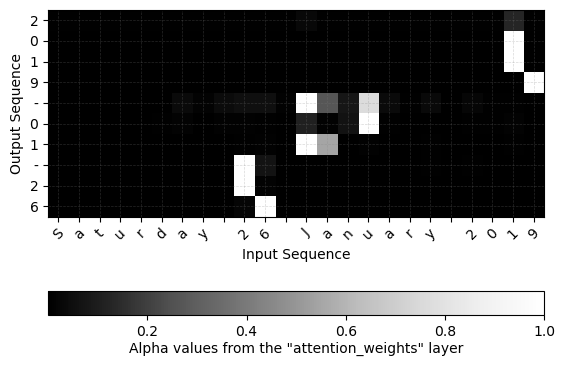

In [24]:
# VISUALIZING ATTENTIONS
att_map = plot_attention_map(model, Tx, Ty, human_vocab, inv_machine_vocab,
                             'Saturday 26 January 2019', n_s=n_s)

In [25]:
# Remarks:
# The output ignores the "Saturday" in the input (sample human text). None of the output timesteps are
# paying much attention to that portion of the input. In addition, January has been correctly translated
# into 01, with the output paying attention to the parts of the input it needs to make the translation.
# The year mostly pays attention to the input's "19" in order to generate "2019."